In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.enable_eager_execution()

In [2]:
ds_images = (
    tf.data.Dataset
    .list_files('/home/bml/datasets/camvid/images/*.png', shuffle=False)
    .map(tf.io.read_file)
    .map(tf.io.decode_png))
ds_masks = (tf.data.Dataset
            .list_files('/home/bml/datasets/camvid/labels/*_S.png', shuffle=False)
            .map(tf.io.read_file)
            .map(tf.io.decode_png))

raw_dataset = tf.data.Dataset.zip((ds_images, ds_masks))

In [3]:
IMG_SIZE = 224

In [4]:
def load_image_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')

    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [5]:
dataset = (raw_dataset
           .map(load_image_train)
           .shuffle(buffer_size=100)
           .cache())

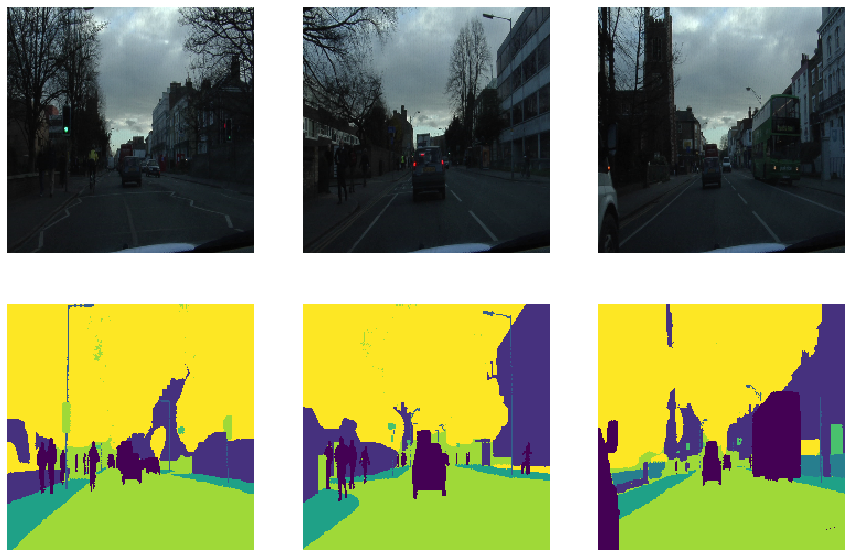

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for idx, (img, mask) in enumerate(dataset.skip(50).take(3)):
    ax[0, idx].imshow(img.numpy())
    ax[0, idx].axis('off')
    ax[1, idx].imshow(mask.numpy()[:, :, 0])
    ax[1, idx].axis('off')

In [7]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def normalize(img): return (img - imagenet_mean) / imagenet_std
def denormalize(img): return (img * imagenet_std) + imagenet_mean
def normalize(img): return img
def denormalize(img): return img

In [8]:
from random import random

In [9]:
def train_augment(image, mask):
    if random() > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_saturation(image, 0.6, 1)
    image = tf.image.random_hue(image, 0.5)
    
    image = normalize(image)
    
    return image, mask

def validation_augment(image, mask):
    image = normalize(image)
    
    return image, mask

In [10]:
train = dataset.skip(100).cache()
validation = dataset.take(100)

In [21]:
DATASET_TRAIN_NUMBER = 602
BATCH_SIZE = 16

In [22]:
train_batches = train.repeat().batch(BATCH_SIZE)
validation_batches = train.batch(BATCH_SIZE)

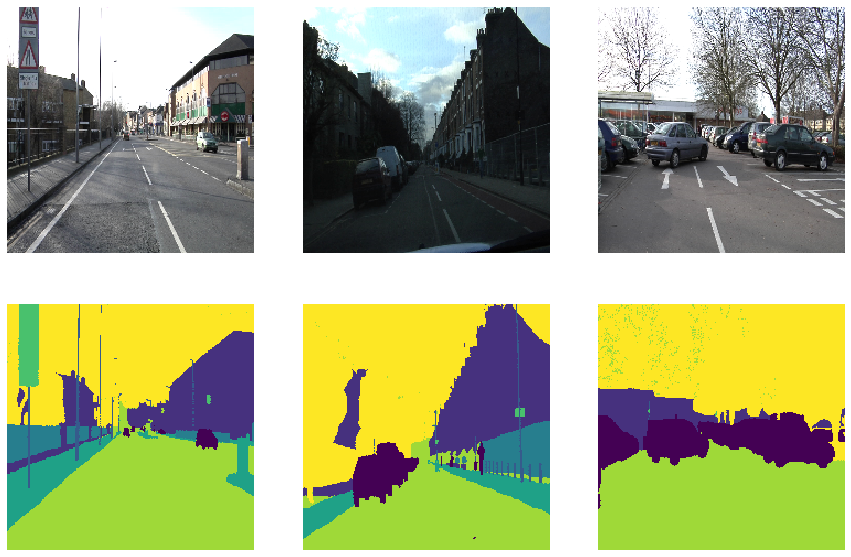

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for idx, (img, mask) in enumerate(train.skip(100).take(3)):
    ax[0, idx].imshow(denormalize(img))
    ax[0, idx].axis('off')
    ax[1, idx].imshow(mask[:, :, 0])
    ax[1, idx].axis('off')

## Model

In [24]:
OUTPUT_CHANNELS = 12

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_SIZE, IMG_SIZE, 3], include_top=False)
layer_names = [
    'block_1_expand_relu',   # 112x112
    'block_3_expand_relu',   # 56x56
    'block_6_expand_relu',   # 28x28
    'block_13_expand_relu',  # 14x14
    'block_16_project',      # 7x7
]
layers = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [26]:
def upsample(filters, size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
    ])


In [27]:
up_stack = [
    upsample(512, 3), # 7x7 -> 14x14
    upsample(256, 3), # 14x14 -> 28x28
    upsample(128, 3), # 28x28 -> 56x56
    upsample(64, 3), # 56x56 -> 112x12
]

In [28]:
last = tf.keras.layers.Conv2DTranspose(
    OUTPUT_CHANNELS, 3, strides=2,
    padding='same', activation='softmax') # 112x112 -> 224x224

In [29]:
inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
skips = down_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])

for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

x = last(x)

model = tf.keras.Model(inputs=inputs, outputs=x)


In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 112, 112, 96 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 14, 14, 512)  1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 14, 14, 1088) 0           sequential_4[0][0]               
                                                                 model_2[1][3]              

In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

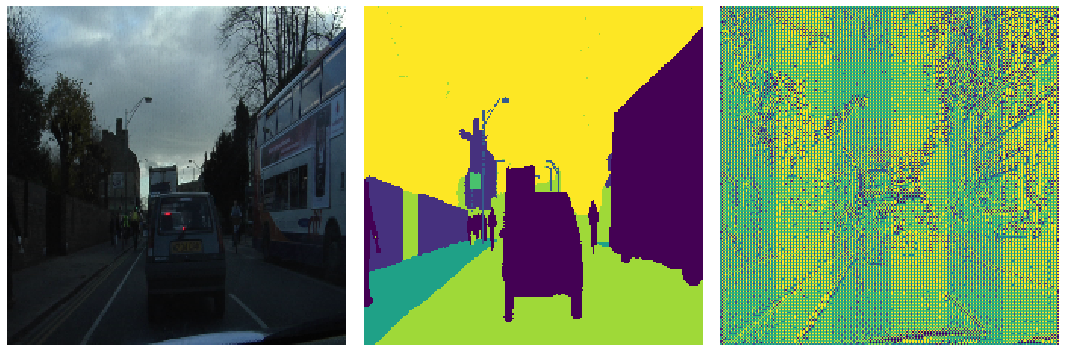

In [32]:
for sample in train.take(1):
    pass

X, y = sample
[y_] = model.predict(tf.stack([X]))

fig, (ax_img, ax_mask, ax_pred) = plt.subplots(1, 3, figsize=(15, 5))

ax_img.imshow(denormalize(X)); ax_img.axis('off')
ax_mask.imshow(y[:, :, 0]); ax_mask.axis('off')
ax_pred.imshow(np.argmax(y_, axis=-1)); ax_pred.axis('off')
plt.tight_layout()

In [33]:
history = model.fit(train_batches,
          epochs=15,
          steps_per_epoch=DATASET_TRAIN_NUMBER // BATCH_SIZE,
          validation_data=validation_batches,
          validation_steps=100 // BATCH_SIZE)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
37/37 [==============================] - 25s 682ms/step - loss: 1.2242 - acc: 0.6240 - val_loss: 1.4130 - val_acc: 0.6111
Epoch 2/15
37/37 [==============================] - 7s 194ms/step - loss: 0.6310 - acc: 0.8161 - val_loss: 1.2764 - val_acc: 0.7003
Epoch 3/15
37/37 [==============================] - 7s 191ms/step - loss: 0.5143 - acc: 0.8468 - val_loss: 1.1763 - val_acc: 0.7252
Epoch 4/15
37/37 [==============================] - 7s 194ms/step - loss: 0.4671 - acc: 0.8580 - val_loss: 1.0476 - val_acc: 0.7464
Epoch 5/15
37/37 [==============================] - 7s 196ms/step - loss: 0.4414 - acc: 0.8639 - val_loss: 0.9092 - val_acc: 0.7687
Epoch 6/15
37/37 [==============================] - 7s 186ms/step - loss: 0.4179 - acc: 0.8697 - val_loss: 0.7789 - val_acc: 0.7872
Epoch 7/15
37/37 [==============================] - 7s 193ms/step - loss: 0.4015 - acc: 0.8740 - val_loss: 0.7262

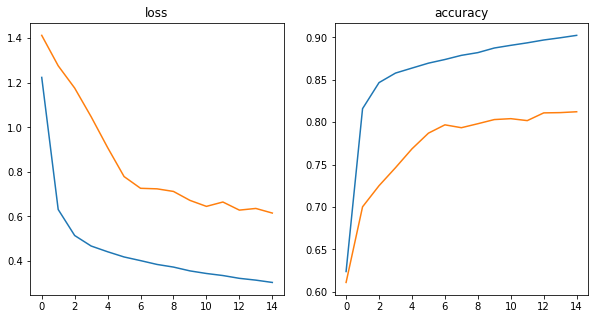

In [34]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10, 5))

ax_loss.set_title('loss')
ax_loss.plot(history.history['loss'])
ax_loss.plot(history.history['val_loss'])

ax_acc.set_title('accuracy')
ax_acc.plot(history.history['acc'])
ax_acc.plot(history.history['val_acc'])

## Data Visualization

In [35]:
for (X, y) in validation.take(5): pass

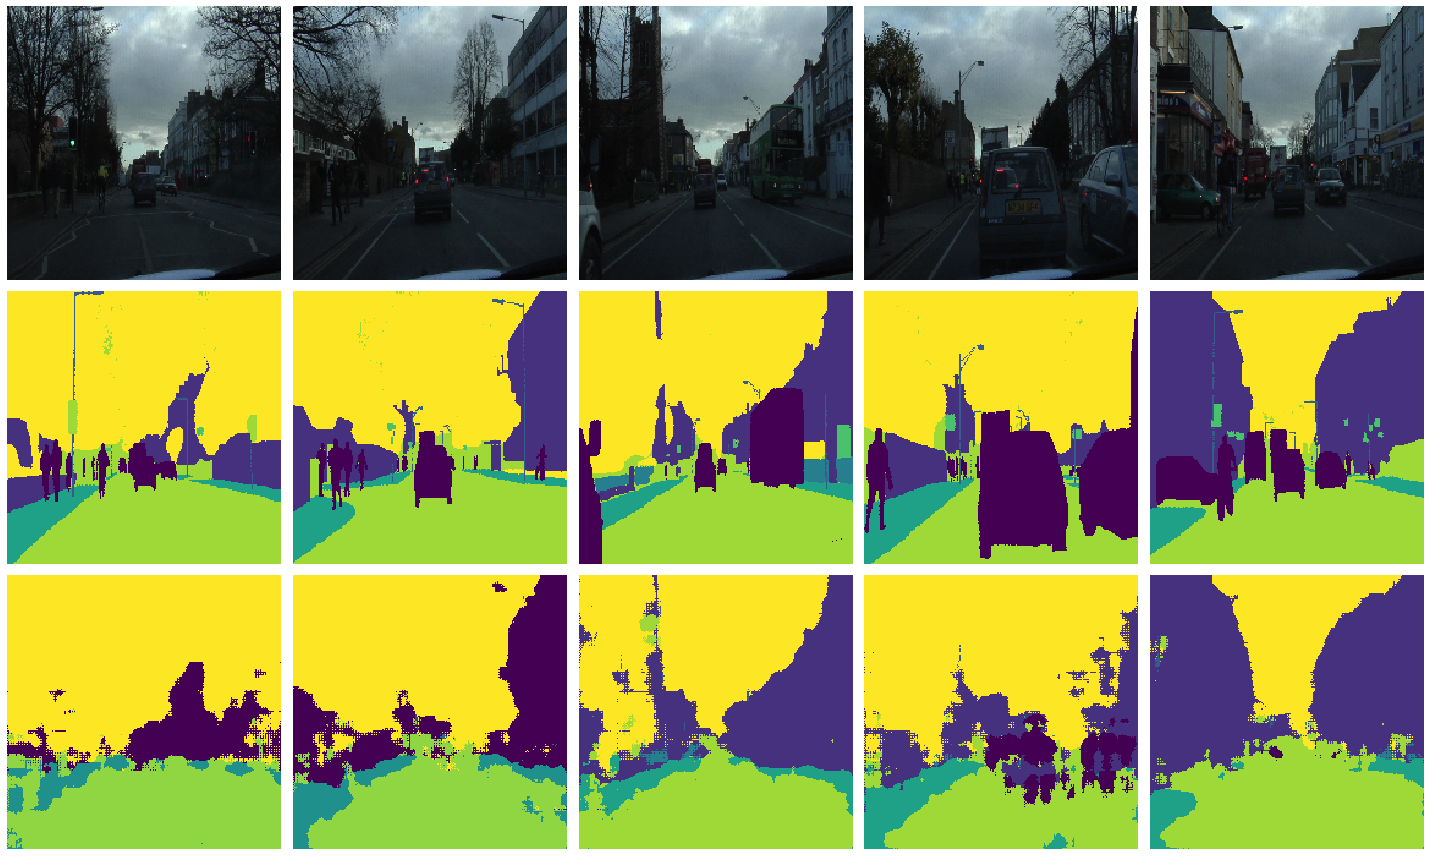

In [36]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))

for idx, (X, y) in enumerate(validation.map(validation_augment).skip(50).take(5)):
    ax[0, idx].imshow(X)
    ax[0, idx].axis('off')
    
    ax[1, idx].imshow(y[:, :, 0])
    ax[1, idx].axis('off')
    
    [y_] = model.predict(tf.stack([X]))
    
    ax[2, idx].imshow(tf.argmax(y_, axis=-1))
    ax[2, idx].axis('off')

plt.tight_layout()

## Fine tuning

In [37]:
model.layers[1].trainable = True

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0004),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
history = model.fit(train_batches,
          epochs=20,
          steps_per_epoch=DATASET_TRAIN_NUMBER // BATCH_SIZE,
          validation_data=validation_batches,
          validation_steps=100 // BATCH_SIZE)

Epoch 1/20
37/37 [==============================] - 63s 2s/step - loss: 0.3016 - acc: 0.9026 - val_loss: 0.6408 - val_acc: 0.8160
Epoch 2/20
37/37 [==============================] - 10s 280ms/step - loss: 0.2820 - acc: 0.9078 - val_loss: 0.6252 - val_acc: 0.8204
Epoch 3/20
37/37 [==============================] - 10s 279ms/step - loss: 0.2475 - acc: 0.9198 - val_loss: 0.5182 - val_acc: 0.8407
Epoch 4/20
37/37 [==============================] - 10s 282ms/step - loss: 0.2258 - acc: 0.9272 - val_loss: 0.5278 - val_acc: 0.8362
Epoch 5/20
37/37 [==============================] - 11s 284ms/step - loss: 0.2132 - acc: 0.9311 - val_loss: 0.5326 - val_acc: 0.8312
Epoch 6/20
37/37 [==============================] - 10s 281ms/step - loss: 0.2014 - acc: 0.9347 - val_loss: 0.5071 - val_acc: 0.8376
Epoch 7/20
37/37 [==============================] - 11s 287ms/step - loss: 0.1926 - acc: 0.9375 - val_loss: 0.5378 - val_acc: 0.8297
Epoch 8/20
37/37 [==============================] - 11s 284ms/step - los

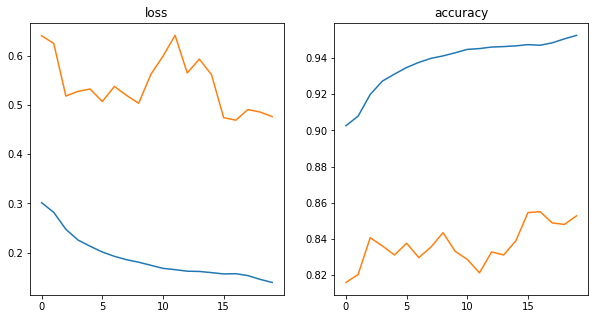

In [40]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10, 5))

ax_loss.set_title('loss')
ax_loss.plot(history.history['loss'])
ax_loss.plot(history.history['val_loss'])

ax_acc.set_title('accuracy')
ax_acc.plot(history.history['acc'])
ax_acc.plot(history.history['val_acc'])

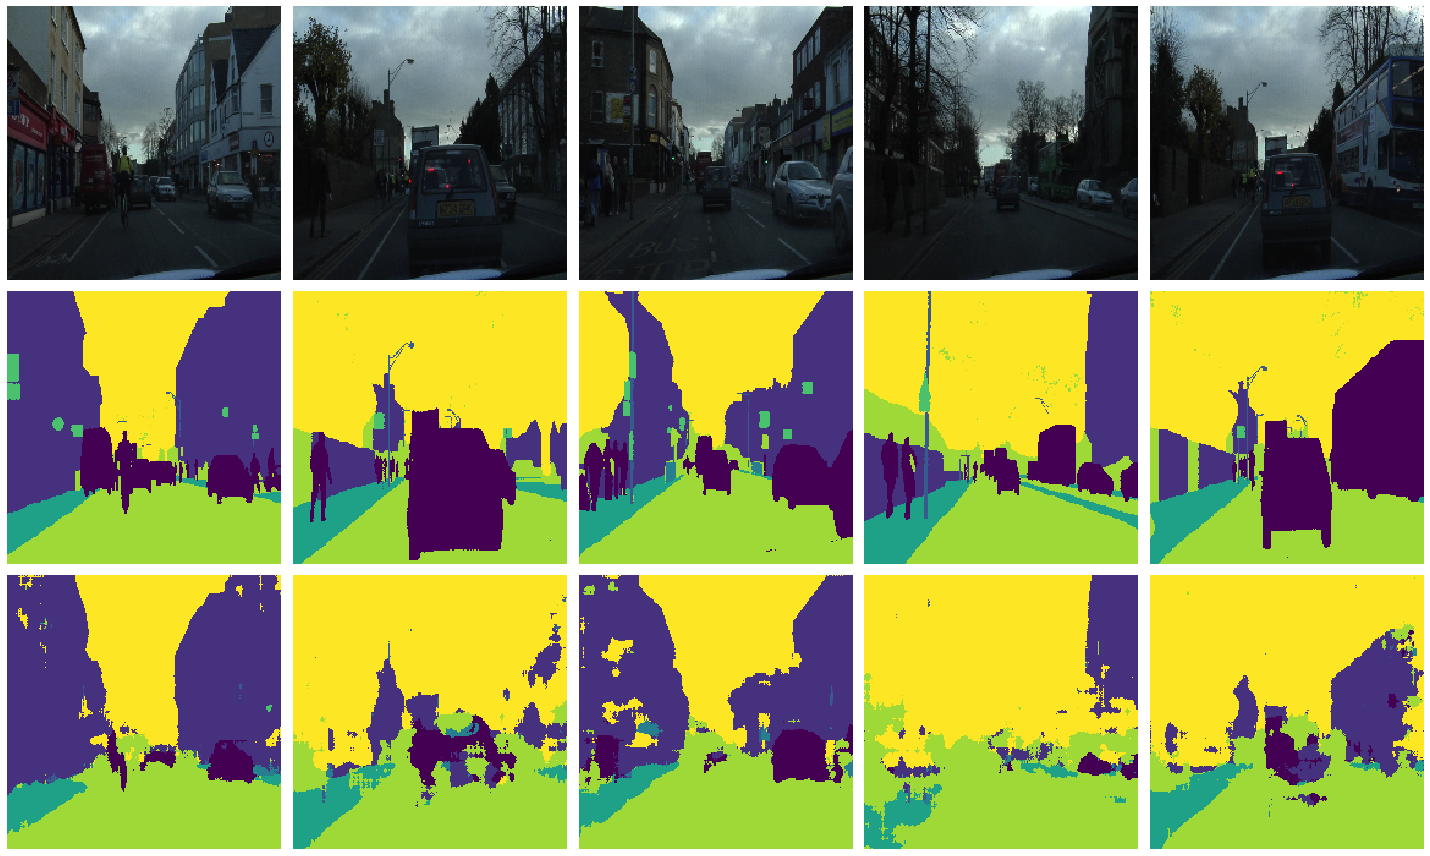

In [43]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))

for idx, (X, y) in enumerate(validation.skip(10).take(5)):
    ax[0, idx].imshow(X)
    ax[0, idx].axis('off')
    
    ax[1, idx].imshow(y[:, :, 0])
    ax[1, idx].axis('off')
    
    [y_] = model.predict(tf.stack([X]))
    
    ax[2, idx].imshow(tf.argmax(y_, axis=-1))
    ax[2, idx].axis('off')

plt.tight_layout()

## Saving the model

In [44]:
model.save('models/road_segmentation_mobilenetv2.h5')